In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Initial Setup**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

sns.set()

In [ ]:
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
start_time = datetime.now()

### **Custom Functions**

In [ ]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).

    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.

    Keyword arguments:

    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None

    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))

    f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='orangered')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)

    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()


def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.

    Keyword arguments:

    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()

    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True

    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(40, 20))
        f_map = sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                            center=0, cmap="RdYlBu")
    plt.show()

## **Data Exploration**

In [ ]:
# Importing the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Btech Labs/RS/RS OEA/dataset/WinnipegDataset.txt')
dataset = dataset.sample(frac=1)

**Dependent variable:**

Crop class, as described above ('label', integer value ranging from 1 to 7)


**Predictive features:**

Polarimetric radar features (49) collected on July 5th, 2012 ('f1' to 'f49', real values)

Polarimetric radar features (49) collected on July 14th, 2012 ('f50' to 'f98', real values)

Optical features (38) collected on July 5th, 2012 ('f99' to 'f136', real values)

Optical features (38) collected on July 14th, 2012 ('f137' to 'f174', real values)

In [ ]:
dataset.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
321677,6,-16.419,-26.557,-17.3110,-19.605,-16.506,-19.877,0.89170,-10.1380,-9.2460,...,0.35802,0.37796,1.00000,0.000000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000
5699,1,-12.518,-19.872,-9.9354,-13.732,-10.625,-14.106,-2.58290,-7.3532,-9.9361,...,0.28395,0.35000,1.11110,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
170185,4,-16.156,-25.782,-15.7220,-17.299,-17.519,-17.613,-0.43370,-9.6263,-10.0600,...,0.40741,0.31623,0.44444,0.246910,0.83333,0.33333,0.33333,1.06090,0.35802,0.47809
310414,6,-16.914,-27.466,-17.1930,-20.637,-16.284,-20.425,0.27937,-10.5520,-10.2730,...,0.23457,-0.42640,1.00000,0.000000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000
297485,6,-16.719,-26.293,-15.7320,-19.315,-15.605,-19.534,-0.98775,-9.5738,-10.5620,...,0.28395,0.57009,2.00000,0.000000,1.00000,0.00000,0.00000,-0.00000,1.00000,1.00000


In [ ]:
class_share = pd.Series(100 * dataset.label.value_counts(normalize=True)).sort_index()
print('Class share\n')
for i in range(0,7):
    print(f'Class {class_share.index[i]}: {class_share.iloc[i]:.2f} %')

Class share

Class 1: 12.02 %
Class 2: 1.10 %
Class 3: 23.22 %
Class 4: 22.73 %
Class 5: 14.46 %
Class 6: 26.11 %
Class 7: 0.35 %


Text(0, 0.5, 'Share (%)')

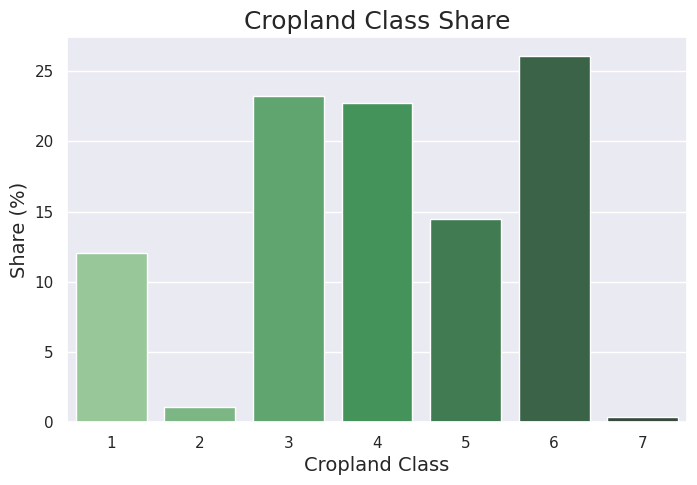

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(ax=ax, x = class_share.index, y = class_share, palette='Greens_d')
plt.title('Cropland Class Share', fontsize=18)
plt.xlabel('Cropland Class', fontsize=14)
plt.ylabel('Share (%)', fontsize=14)

## **Correlation Analysis**

In [ ]:
highly_correlated_feature_pairs = []
highly_correlated_features_to_drop = []

correlation_matrix = dataset.corr().abs()
upper_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
for row in range(upper_matrix.shape[0]):
    for column in range(upper_matrix.shape[1]):
        if upper_matrix.iloc[row, column] > 0.95:
            highly_correlated_feature_pairs.append([row, column, upper_matrix.iloc[row, column]])

print(f'Number of highly intercorrelated feature pairs: {len(highly_correlated_feature_pairs)}')

Number of highly intercorrelated feature pairs: 117


In [ ]:
n

In [ ]:
highly_correlated_feature_pairs = pd.DataFrame(highly_correlated_feature_pairs).sort_values(by=[2], ascending=False)
highly_correlated_feature_pairs.columns = ['feature_1', 'feature_2', 'correl']
highly_correlated_feature_pairs.head(10)

,feature_1,feature_2,correl
4,2,39,1.000000
38,51,88,1.000000
109,151,153,1.000000
45,54,86,1.000000
8,5,37,1.000000
102,142,147,1.000000
113,156,157,0.998716
13,7,15,0.995524
10,6,38,0.995455
60,62,79,0.995254


Features to be dropped are pinned on a correlation map and removed from the dataset.

In [ ]:
highly_correlated_features_to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.95)]
dataset = dataset.drop(dataset[highly_correlated_features_to_drop], axis=1)

In [ ]:
nr_features = dataset.shape[1] - 1
print(f'Optimized number of features: {nr_features}')

Optimized number of features: 102


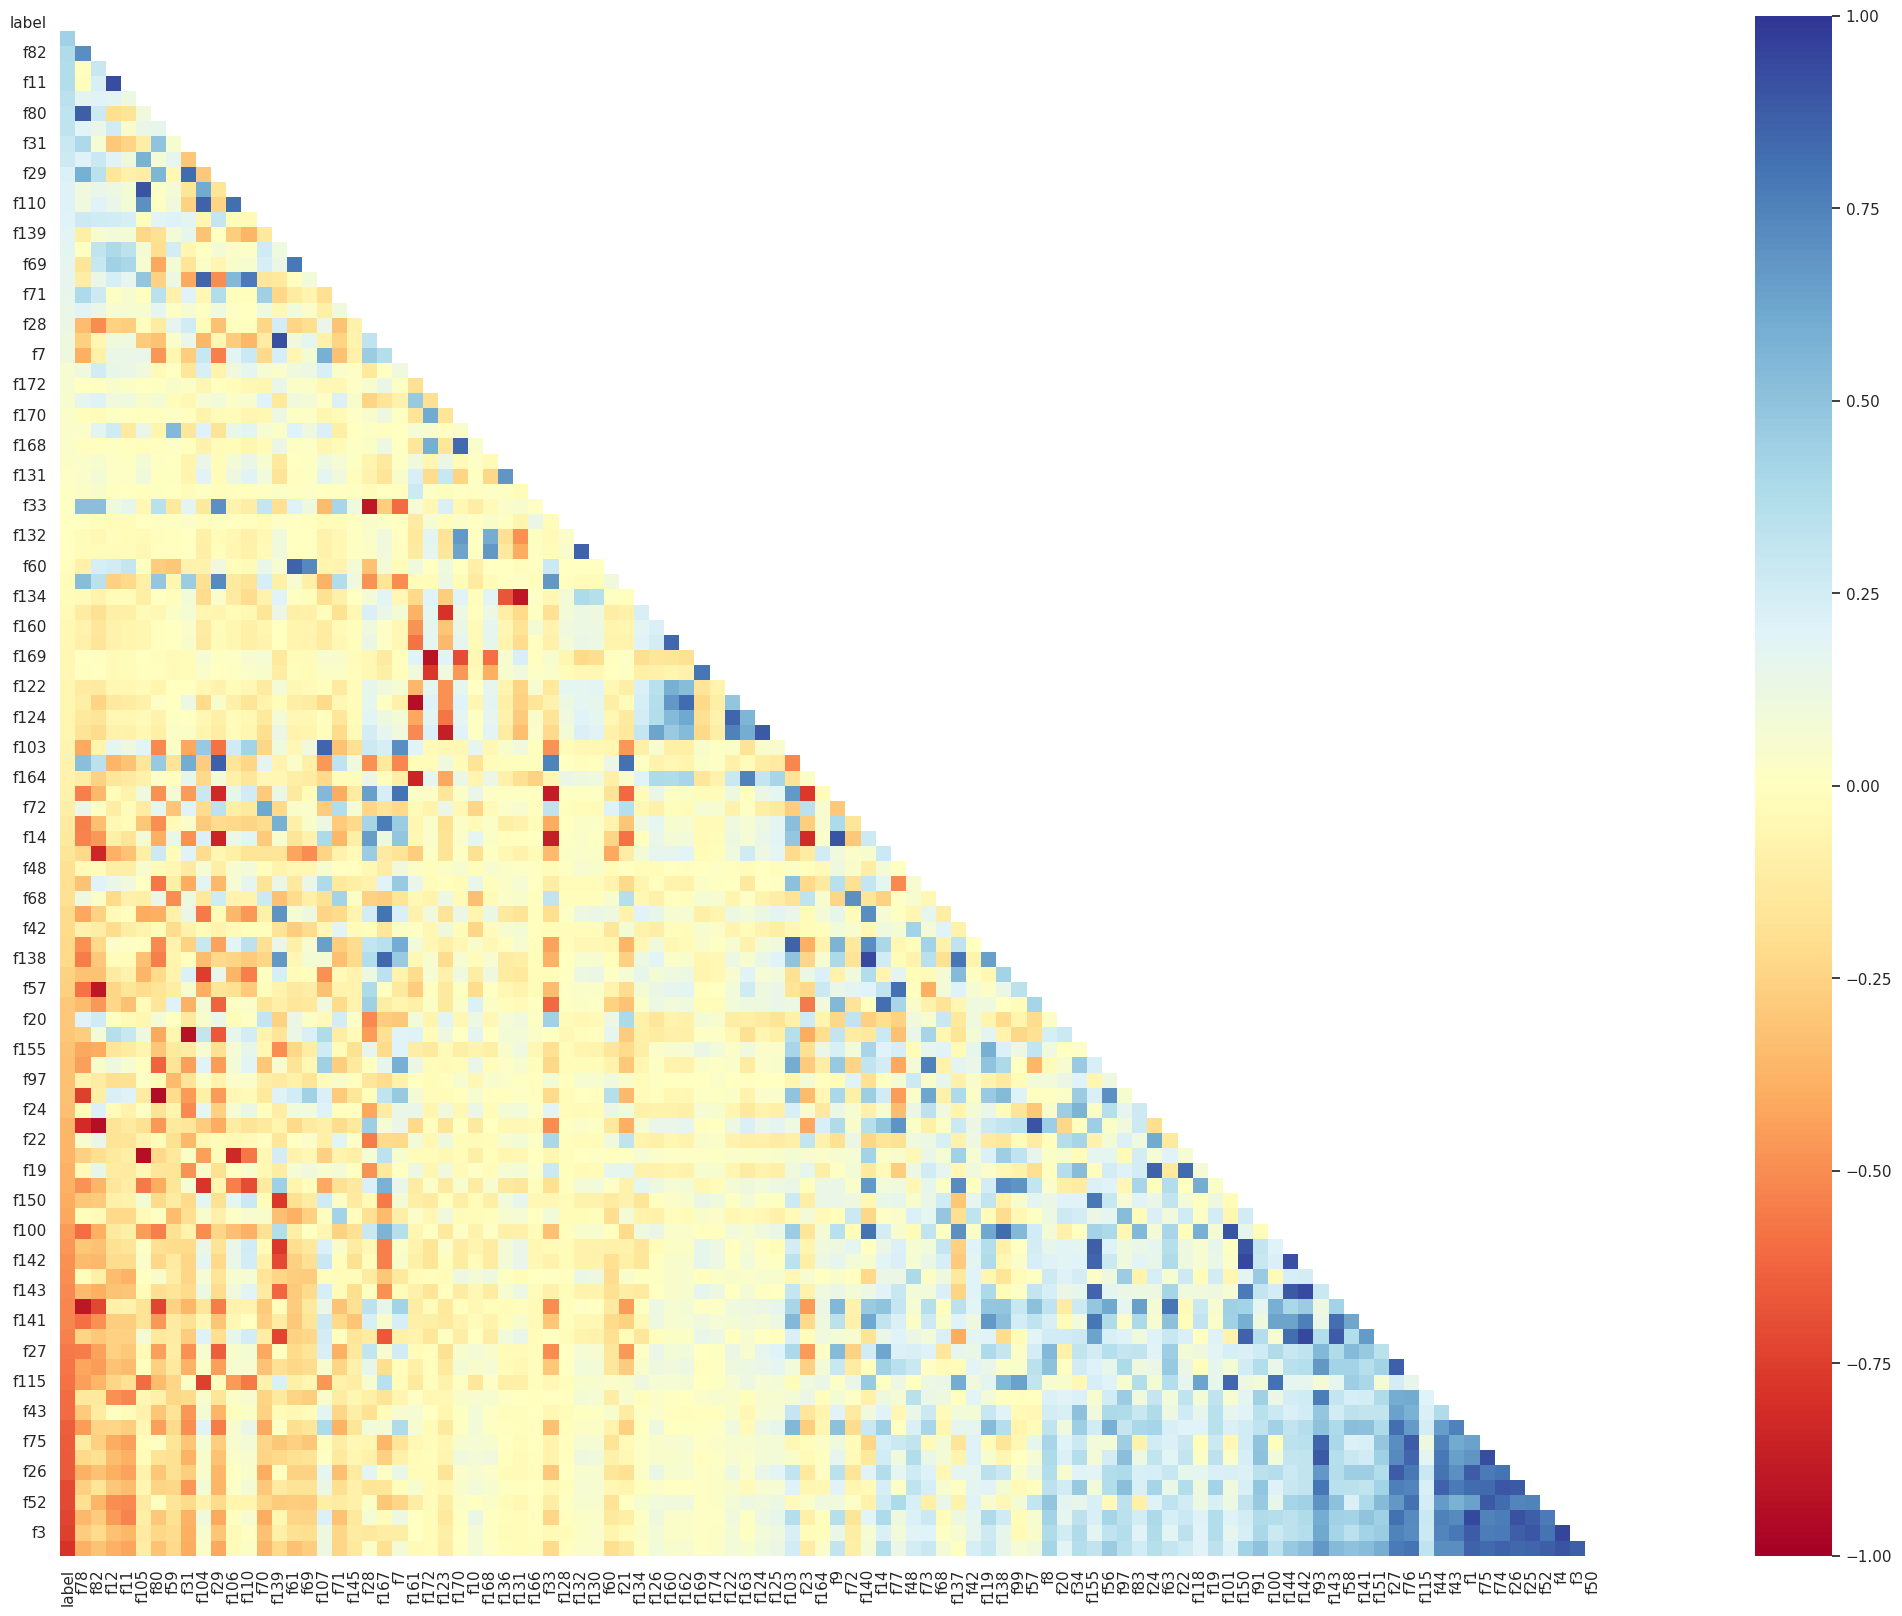

In [ ]:
correlation_map(dataset, 'label', nr_features)

## **Feature assessment**

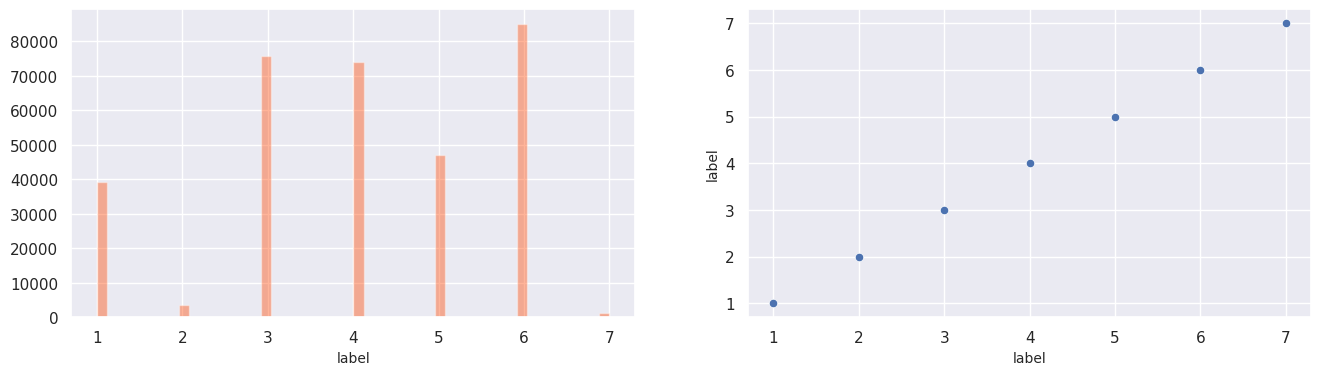

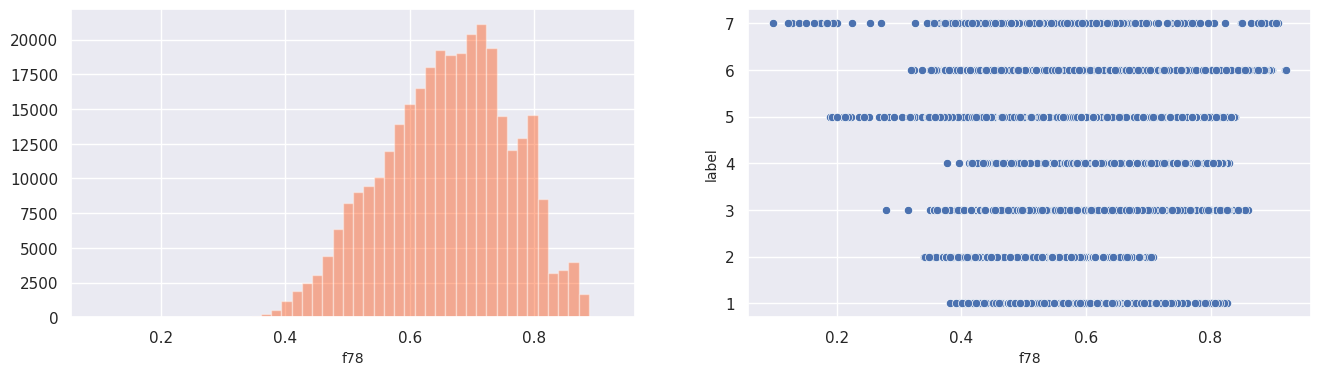

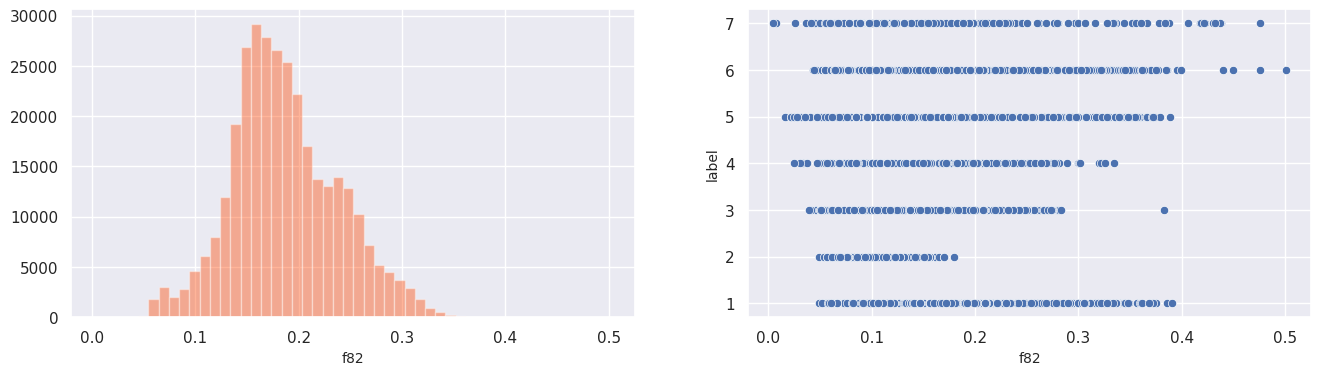

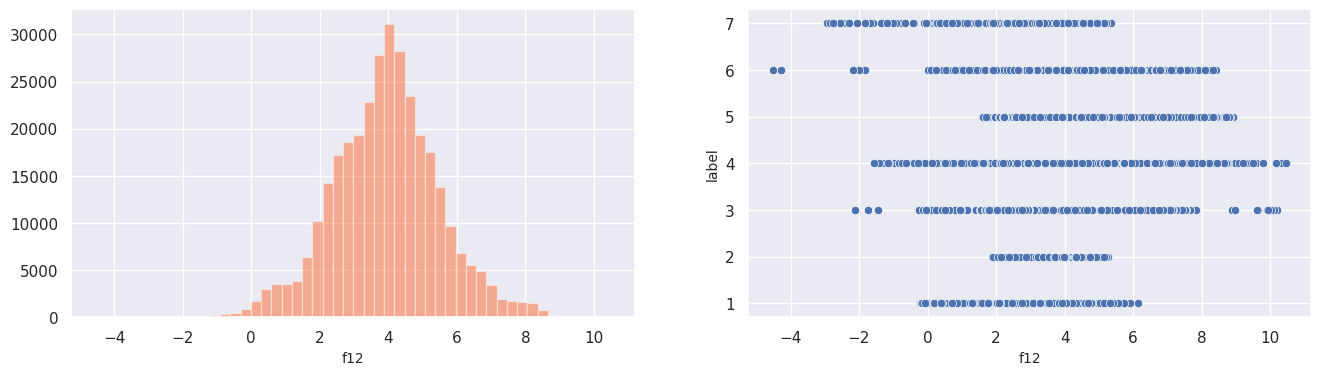

In [ ]:
most_correlated_features = dataset.corr().nlargest(4,'label')['label'].index

for column in most_correlated_features:
    assessment(dataset, 'label', column, -1)

**The analysis shows that some variables are indeed skewed.**

## **Segregating train and test datasets**

In [ ]:
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, 0:1]

In [ ]:
train_size = round(0.8 * len(X))

In [ ]:
X_train = X.iloc[:train_size, :].values
y_train = y.iloc[:train_size]

X_test = X.iloc[train_size:, :].values
y_test = y.iloc[train_size:]

In [ ]:
class_count = pd.Series(y_test.label.value_counts()).sort_index()
print('Class count - Test labels\n')
for i in range(0,7):
    print(f'Class {class_count.index[i]}: {class_count.iloc[i]}')

Class count - Test labels

Class 1: 7794
Class 2: 771
Class 3: 15002
Class 4: 14798
Class 5: 9531
Class 6: 17055
Class 7: 216


**Label tensors (numpy arrays) are created for each separate algorithms (random forest and neural network).**

In [ ]:
y_train_rf = y_train.label.values
y_test_rf = y_test.label.values

y_train_ann = pd.get_dummies(y_train.label).values
y_test_ann = pd.get_dummies(y_test.label).values

## **Feature scaling**

Scaling is performed on the training feature set only and applied to both training and testing feature sets (with the 'fit_transform' and 'transform' methods, respectively).

In [ ]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Machine Learning**

## **Method 1 : Random Forest Algorithm**

The classifier will be instantiated with n_estimators = 100 (i.e. the forest will comprise 100 decision trees) and n_jobs = 4 (allowing for the use of 4 processing cores).


Selected a number of trees are relatively close to the final number of features (102) for a first shot. However, a more robust optimization of relevant hyperparameters is recommended, e.g. through the use of validation curves.

In [ ]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, n_jobs=4)

random_forest_classifier.fit(X_train, y_train_rf)

RandomForestClassifier(n_jobs=4)

**Random Forest Predications**

In [ ]:
y_pred_rf = random_forest_classifier.predict(X_test)

In [ ]:
print(f'Predicted class: {y_pred_rf[0]}')
print(f'Actual class: {y_test_rf[0]}')

Predicted class: 3
Actual class: 3


## **Method 2 : Artificial Neural Network**

The artificial neural network (ANN) architecture comprises a sequential structure with:

* one input layer (102 input nodes)  
* three hidden layers (204, 204 and 102 nodes, respectively)  
* one seven-node output layer  

Activation Function = Relu (For Hidden Layers)+ Softmax (for Output Layer)  

Optimizer = Adam

Loss Function = categorical_crossentropy

Performance Matric = Accuracy


In [ ]:
# ANN
ann_classifier = Sequential()

# Input layer and first dense layer
ann_classifier.add(Dense(units = 204, kernel_initializer = 'uniform', activation = 'relu', input_dim = 102))
ann_classifier.add(Dropout(0.1))

# Second dense layer
ann_classifier.add(Dense(units = 204, kernel_initializer = 'uniform', activation = 'relu'))
ann_classifier.add(Dropout(0.1))

# Third dense layer
ann_classifier.add(Dense(units = 102, kernel_initializer = 'uniform', activation = 'relu'))
ann_classifier.add(Dropout(0.1))

# Output layer
ann_classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

# Model compilation

optim = Adam(learning_rate=0.0005)

ann_classifier.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
ann_train_history = ann_classifier.fit(X_train, y_train_ann, batch_size = 64, epochs = 100, verbose=0)

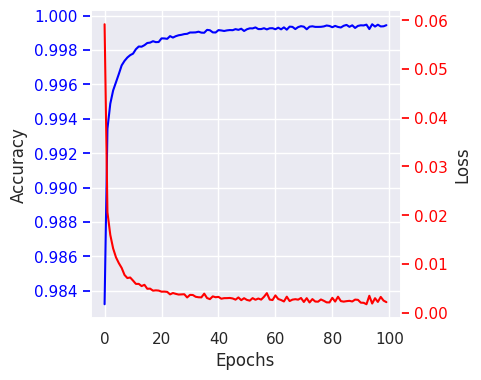

In [ ]:
fig, ax1 = plt.subplots(figsize=(4,4))
sns.set_style("darkgrid")
ax2 = ax1.twinx()
ax1.plot(ann_train_history.history['accuracy'], color='blue')
ax2.plot(ann_train_history.history['loss'], color='red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y', colors='blue')
ax2.set_ylabel('Loss')
ax2.tick_params(axis='y', colors='red')
ax2.grid(False)
plt.show()

**ANN Predications**

In [ ]:
y_pred_ann = ann_classifier.predict(X_test)
for i in range(len(y_pred_ann)):
    for j in range(7):
        if y_pred_ann[i][j] == y_pred_ann[i].max():
            y_pred_ann[i][j] = 1
        else:
            y_pred_ann[i][j] = 0
y_pred_ann = y_pred_ann.astype(int)

2037/2037 [==============================] - 3s 1ms/step


The final array is 'binarized': the array element with the highest value will be converted to '1' while all other array elements will be converted to '0'.

In [ ]:
print(f'Predicted: {y_pred_ann[0]}')
print(f'Actual: {y_test_ann[0]}')

Predicted: [0 0 1 0 0 0 0]
Actual: [False False  True False False False False]


# **Performance Evaluation**

### **Classification Performance : Random Forest Algorithm**

In [ ]:
rf_cm = np.zeros((7,7))

In [ ]:
rf_pred_correct = 0
rf_pred_incorrect = 0
for i in range(len(y_test)):
    rf_index_test = y_test_rf[i] - 1
    rf_index_pred = y_pred_rf[i] - 1
    rf_cm[rf_index_test][rf_index_pred] += 1
    if rf_index_test == rf_index_pred:
        rf_pred_correct += 1
    else:
        rf_pred_incorrect += 1


In [ ]:
rf_cmatrix = pd.DataFrame(rf_cm.astype(int),
                          index = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'],
                          columns = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'])
rf_cmatrix

,Corn,Pea,Canola,Soy,Oat,Wheat,Broadleaf
Corn,7775,0,4,8,2,2,3
Pea,0,769,0,2,0,0,0
Canola,1,0,14987,3,3,8,0
Soy,6,0,6,14760,11,15,0
Oat,3,0,11,16,9455,42,4
Wheat,1,0,4,15,33,17000,2
Broadleaf,3,0,2,0,2,1,208


In [ ]:
rf_accuracy = accuracy_score(y_test_rf, y_pred_rf)
rf_precision, rf_recall, rf_f_score, rf_support = precision_recall_fscore_support(y_test_rf, y_pred_rf, average='macro')
print(f'Accuracy: {rf_accuracy * 100:.2f} %')
print(f'Precision: {rf_precision * 100:.2f} %')
print(f'Recall: {rf_recall * 100:.2f} %')
print(f'F-Score: {rf_f_score * 100:.2f} %')

Accuracy: 99.67 %
Precision: 99.18 %
Recall: 99.19 %
F-Score: 99.18 %


In [ ]:
print('Accuracy per class\n')
for i in range(len(rf_cmatrix)):
    class_accuracy = rf_cmatrix.iloc[i,i] / rf_cmatrix.sum(axis=0)[i]
    print(f'{rf_cmatrix.columns[i]}: {class_accuracy*100:.2f} %')

Accuracy per class

Corn: 99.82 %
Pea: 100.00 %
Canola: 99.82 %
Soy: 99.70 %
Oat: 99.46 %
Wheat: 99.60 %
Broadleaf: 95.85 %


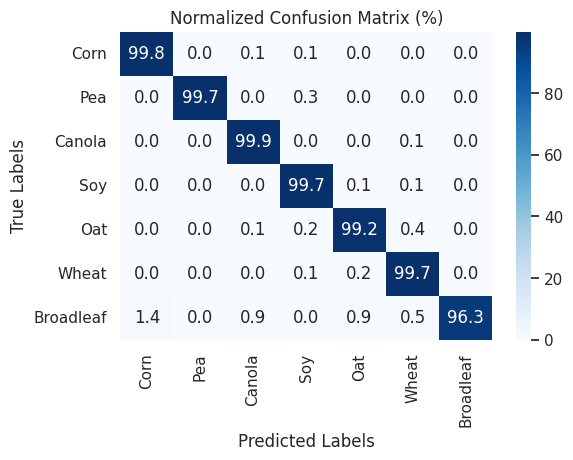

In [ ]:
# Normalize the confusion matrix to get percentages
rf_cmatrix_normalized = rf_cmatrix.div(rf_cmatrix.sum(axis=1), axis=0) * 100

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cmatrix_normalized, annot=True, cmap='Blues', fmt='.1f')
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### **Classification Performance : ANN Algorithm**

In [ ]:
ann_cm = np.zeros((7,7))

In [ ]:
ann_pred_correct = 0
ann_pred_incorrect = 0
for i in range(len(y_test_ann)):
    if y_pred_ann[i].sum() > 0:
        ann_index_test = np.where(y_test_ann[i] == 1)[0][0]
        ann_index_pred = np.where(y_pred_ann[i] == 1)[0][0]
        ann_cm[ann_index_test][ann_index_pred] += 1
        if ann_index_test == ann_index_pred:
            ann_pred_correct += 1
        else:
            ann_pred_incorrect += 1

In [ ]:
ann_cmatrix = pd.DataFrame(ann_cm.astype(int),
                           index = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'],
                           columns = ['Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'])
ann_cmatrix

,Corn,Pea,Canola,Soy,Oat,Wheat,Broadleaf
Corn,7782,0,1,5,2,1,3
Pea,0,771,0,0,0,0,0
Canola,1,0,14994,2,2,3,0
Soy,2,0,1,14785,6,4,0
Oat,0,0,5,2,9515,7,2
Wheat,0,1,2,5,30,17015,2
Broadleaf,1,0,0,0,0,2,213


In [ ]:
ann_accuracy = accuracy_score(y_test_ann, y_pred_ann)
ann_precision, ann_recall, ann_f_score, ann_support = precision_recall_fscore_support(y_test_ann, y_pred_ann, average='macro')
print(f'Accuracy: {ann_accuracy * 100:.2f} %')
print(f'Precision: {ann_precision * 100:.2f} %')
print(f'Recall: {ann_recall * 100:.2f} %')
print(f'F-Score: {ann_f_score * 100:.2f} %')

Accuracy: 99.86 %
Precision: 99.42 %
Recall: 99.70 %
F-Score: 99.56 %


In [ ]:
print('Accuracy per class\n')
for i in range(len(ann_cmatrix)):
    class_accuracy = ann_cmatrix.iloc[i,i] / ann_cmatrix.sum(axis=0)[i]
    print(f'{ann_cmatrix.columns[i]}: {class_accuracy*100:.2f} %')

Accuracy per class

Corn: 99.95 %
Pea: 99.87 %
Canola: 99.94 %
Soy: 99.91 %
Oat: 99.58 %
Wheat: 99.90 %
Broadleaf: 96.82 %


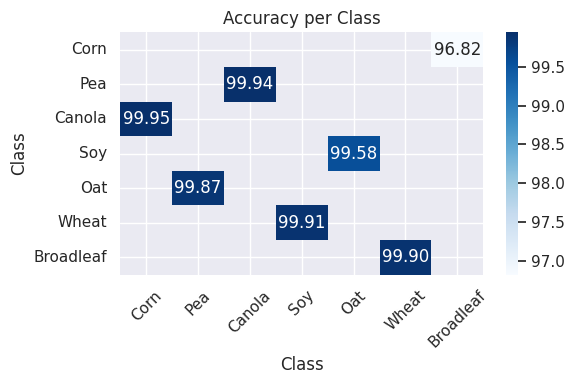

In [ ]:
 # Calculate accuracy per class
class_accuracies = [(ann_cmatrix.iloc[i, i] / ann_cmatrix.sum(axis=0)[i]) * 100 for i in range(len(ann_cmatrix))]

# Create a DataFrame for accuracy per class
accuracy_df = pd.DataFrame({'Class': ann_cmatrix.columns, 'Accuracy (%)': class_accuracies})

# Add a unique identifier to each class to avoid ValueError
accuracy_df['Class_ID'] = range(len(accuracy_df))

# Reshape the DataFrame for heatmap
accuracy_heatmap = accuracy_df.pivot(index='Class', columns='Class_ID', values='Accuracy (%)')

# Plotting the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(accuracy_heatmap, annot=True, cmap='Blues', fmt='.2f', xticklabels=accuracy_df['Class'].values, yticklabels=accuracy_df['Class'].values)
plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# **Performance Comparison between Random Forest and ANN**

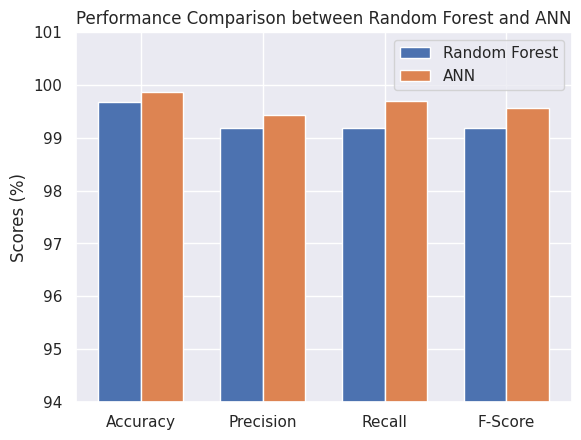

In [ ]:

# Define performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F-Score']
rf_scores = [rf_accuracy * 100, rf_precision * 100, rf_recall * 100, rf_f_score * 100]
ann_scores = [ann_accuracy * 100, ann_precision * 100, ann_recall * 100, ann_f_score * 100]

# Plotting
x = range(len(metrics))
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x, rf_scores, width, label='Random Forest')
bars2 = ax.bar([p + width for p in x], ann_scores, width, label='ANN')

# Set y-axis limits
ax.set_ylim(94, 101)  # Adjusted y-axis limits

ax.set_ylabel('Scores (%)')  # Adjusted y-axis label
ax.set_title('Performance Comparison between Random Forest and ANN')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()